In [6]:
import os
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import cv2

In [11]:

# ============================================================
#   PREPROCESAMIENTO (convierte cualquier obs → [1, 84, 84])
# ============================================================
def preprocess_obs(obs):
    # Si viene (H, W)
    if len(obs.shape) == 2:
        gray = obs

    # Si viene (H, W, C)
    elif len(obs.shape) == 3:
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)

    else:
        raise ValueError("Observación rara con shape: " + str(obs.shape))

    # Resize
    gray = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

    # (1, 84, 84)
    gray = np.expand_dims(gray, axis=0)

    return gray.astype(np.float32)


# ============================================================
#   MODELO DQN SIMPLE
# ============================================================
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super().__init__()
        c, h, w = obs_shape  # debería ser (1, 84, 84)

        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            flat_size = self.net(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = x / 255.0
        x = self.net(x)
        return self.head(x)


# ============================================================
#   REPLAY BUFFER SIMPLE
# ============================================================
class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = zip(*batch)
        return (
            torch.tensor(np.array(s), dtype=torch.float32),
            torch.tensor(a),
            torch.tensor(r, dtype=torch.float32),
            torch.tensor(np.array(s2), dtype=torch.float32),
            torch.tensor(d, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


In [17]:
import matplotlib.pyplot as plt

def train_dqn(
    env_id="ALE/Galaxian-v5",
    episodes=200,
    gamma=0.99,
    lr=1e-4,
    batch_size=32,
    eps_start=1.0,
    eps_end=0.1,
    eps_decay=30000,
):

    env = gym.make(env_id)

    obs, info = env.reset()
    obs = preprocess_obs(obs)

    n_actions = env.action_space.n
    obs_shape = obs.shape

    policy_net = DQN(obs_shape, n_actions)
    target_net = DQN(obs_shape, n_actions)
    target_net.load_state_dict(policy_net.state_dict())

    buffer = ReplayBuffer()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    epsilon = eps_start
    step_count = 0
    best_score = -9999

    os.makedirs("models", exist_ok=True)

    # ========================================================
    # MÉTRICAS
    # ========================================================
    scores = []
    losses = []
    epsilons = []

    # ========================================================
    # LOOP DE EPISODIOS
    # ========================================================
    for ep in range(episodes):
        obs, info = env.reset()
        obs = preprocess_obs(obs)

        done = False
        truncated = False
        total_reward = 0

        ep_loss = 0
        loss_steps = 0

        while not (done or truncated):
            step_count += 1

            # -----------------------------
            #   EPSILON-GREEDY
            # -----------------------------
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    inp = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                    qvals = policy_net(inp)
                    action = int(torch.argmax(qvals, dim=1))

            # Step
            next_obs, reward, done, truncated, info = env.step(action)
            next_obs = preprocess_obs(next_obs)
            total_reward += reward

            buffer.push(obs, action, reward, next_obs, done)
            obs = next_obs

            # -----------------------------
            #   APRENDIZAJE
            # -----------------------------
            if len(buffer) >= batch_size:
                s, a, r, s2, d = buffer.sample(batch_size)

                q_pred = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    q_next = target_net(s2).max(1)[0]
                    q_target = r + gamma * q_next * (1 - d)

                loss = nn.MSELoss()(q_pred, q_target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                ep_loss += loss.item()
                loss_steps += 1

            # -----------------------------
            #   TARGET NET UPDATE
            # -----------------------------
            if step_count % 5000 == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # -----------------------------
            #   EPSILON DECAY
            # -----------------------------
            epsilon = max(eps_end, eps_start * np.exp(-step_count / eps_decay))

        # ---- episodio terminado ----
        scores.append(total_reward)
        epsilons.append(epsilon)
        losses.append(ep_loss / loss_steps if loss_steps > 0 else 0)

        print(f"EP {ep} | Score={total_reward} | eps={epsilon:.3f}")

        if total_reward > best_score:
            best_score = total_reward
            torch.save(policy_net.state_dict(), "models/best_model.pth")
            print(f"🔥 Mejor modelo guardado! Score={best_score}")

    env.close()
    print("Entrenamiento finalizado. Mejor score:", best_score)

    # ========================================================
    #   G R Á F I C A S
    # ========================================================

    # SCORE
    plt.figure(figsize=(12,6))
    plt.plot(scores)
    plt.title("DQN - Score por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Score")
    plt.grid()
    plt.savefig("dqn_scores.png")
    plt.show()

    # LOSS
    plt.figure(figsize=(12,6))
    plt.plot(losses)
    plt.title("DQN - Loss promedio por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Loss")
    plt.grid()
    plt.savefig("dqn_losses.png")
    plt.show()

    # EPSILON
    plt.figure(figsize=(12,6))
    plt.plot(epsilons)
    plt.title("DQN - Epsilon por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Epsilon")
    plt.grid()
    plt.savefig("dqn_epsilon.png")
    plt.show()


In [13]:
# ============================================================
#   POLÍTICA PARA PLAY.PY
# ============================================================
def load_trained_policy(path="models/best_model.pth", env_id="ALE/Galaxian-v5"):
    env = gym.make(env_id)
    obs, info = env.reset()
    obs = preprocess_obs(obs)

    n_actions = env.action_space.n
    obs_shape = obs.shape

    model = DQN(obs_shape, n_actions)
    model.load_state_dict(torch.load(path, map_location="cpu"))
    model.eval()

    def policy(obs_raw):
        obs = preprocess_obs(obs_raw)
        with torch.no_grad():
            t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            qvals = model(t)
            return int(torch.argmax(qvals, dim=1))

    return policy

EP 0 | Score=440.0 | eps=0.984
🔥 Mejor modelo guardado! Score=440.0
EP 1 | Score=1310.0 | eps=0.960
🔥 Mejor modelo guardado! Score=1310.0
EP 2 | Score=1130.0 | eps=0.925
EP 3 | Score=680.0 | eps=0.906
EP 4 | Score=610.0 | eps=0.890
EP 5 | Score=1890.0 | eps=0.846
🔥 Mejor modelo guardado! Score=1890.0
EP 6 | Score=1120.0 | eps=0.818
EP 7 | Score=1050.0 | eps=0.794
EP 8 | Score=660.0 | eps=0.777
EP 9 | Score=380.0 | eps=0.769
EP 10 | Score=540.0 | eps=0.761
EP 11 | Score=550.0 | eps=0.748
EP 12 | Score=740.0 | eps=0.733
EP 13 | Score=1050.0 | eps=0.714
EP 14 | Score=840.0 | eps=0.696
EP 15 | Score=1870.0 | eps=0.666
EP 16 | Score=430.0 | eps=0.658
EP 17 | Score=550.0 | eps=0.649
EP 18 | Score=680.0 | eps=0.636
EP 19 | Score=1260.0 | eps=0.610
Entrenamiento finalizado. Mejor score: 1890.0


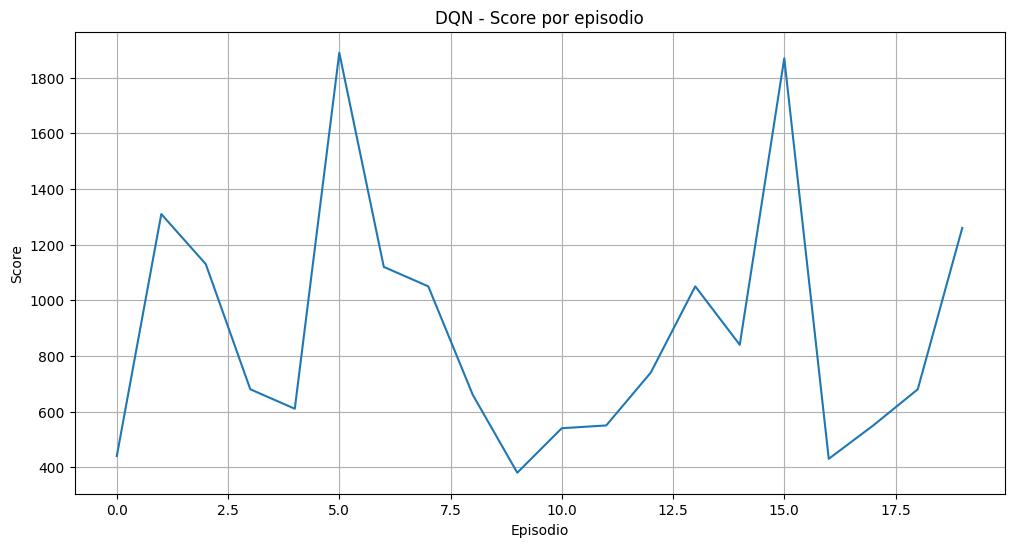

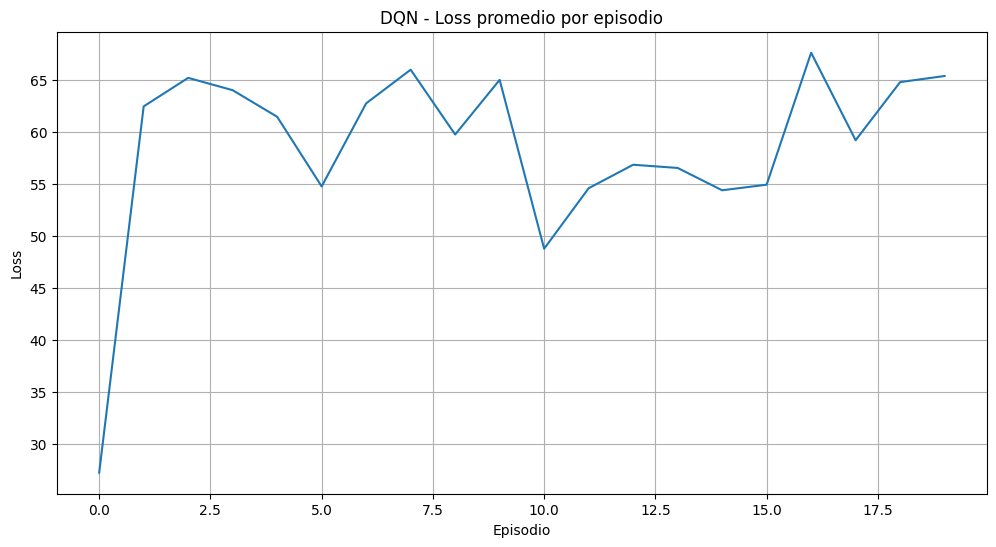

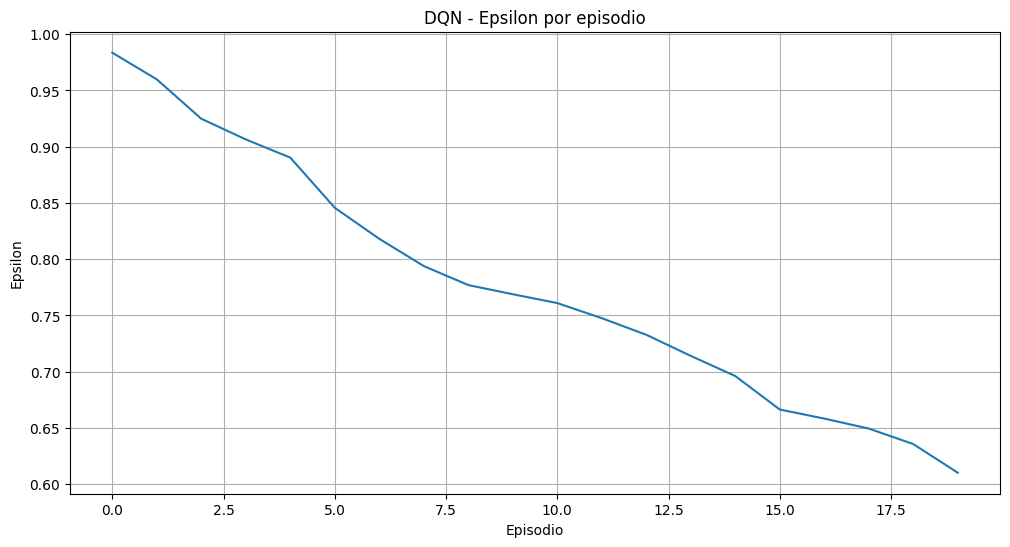

In [19]:
train_dqn(episodes=20)

In [22]:
# ============================================================
#   PREPROCESAMIENTO — [1, 84, 84]
# ============================================================
def preprocess_obs(obs):
    if len(obs.shape) == 2:
        gray = obs
    elif len(obs.shape) == 3:
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError(f"Observación rara: {obs.shape}")

    gray = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    gray = np.expand_dims(gray, 0)

    return gray.astype(np.float32)


# ============================================================
#   A2C NETWORK: ACTOR + CRITIC COMPARTEN BASE CNN
# ============================================================
class A2C(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super().__init__()
        c, h, w = obs_shape

        self.cnn = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
        )

        # calcular tamaño
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            flat = self.cnn(dummy).shape[1]

        # Actor
        self.actor = nn.Sequential(
            nn.Linear(flat, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

        # Critic
        self.critic = nn.Sequential(
            nn.Linear(flat, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x / 255.0
        feats = self.cnn(x)
        logits = self.actor(feats)
        value = self.critic(feats)
        return logits, value



In [20]:

def train_a2c(
    env_id="ALE/Galaxian-v5",
    episodes=200,
    gamma=0.99,
    lr=1e-4,
    entropy_beta=0.001
):

    env = gym.make(env_id)

    obs, info = env.reset()
    obs = preprocess_obs(obs)

    n_actions = env.action_space.n
    obs_shape = obs.shape

    model = A2C(obs_shape, n_actions)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_score = -9999
    os.makedirs("models_a2c", exist_ok=True)

    # =============================
    # MÉTRICAS
    # =============================
    scores = []
    policy_losses = []
    value_losses = []
    entropy_losses = []
    total_losses = []

    for ep in range(episodes):
        obs, info = env.reset()
        obs = preprocess_obs(obs)

        done = False
        truncated = False
        total_reward = 0

        ep_policy_loss = 0
        ep_value_loss = 0
        ep_entropy_loss = 0
        ep_total_loss = 0

        while not (done or truncated):
            # --- forward ---
            obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            logits, value = model(obs_t)

            # acción
            probs = torch.softmax(logits, dim=1)
            dist = torch.distributions.Categorical(probs)
            action = int(dist.sample())

            # step
            next_obs, reward, done, truncated, _ = env.step(action)
            next_obs = preprocess_obs(next_obs)
            total_reward += reward

            # target
            with torch.no_grad():
                next_t = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0)
                _, next_value = model(next_t)
                target = reward + gamma * next_value * (1 - int(done))

            advantage = (target - value).detach()

            # pérdidas
            log_prob = dist.log_prob(torch.tensor(action))
            policy_loss = -log_prob * advantage
            value_loss = nn.MSELoss()(value, target)
            entropy_loss = -entropy_beta * (probs * torch.log(probs + 1e-8)).sum()

            loss = policy_loss + value_loss + entropy_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # acumular métricas por episodio
            ep_policy_loss += policy_loss.item()
            ep_value_loss += value_loss.item()
            ep_entropy_loss += entropy_loss.item()
            ep_total_loss += loss.item()

            obs = next_obs

        # ---- episodio terminado ----
        scores.append(total_reward)
        policy_losses.append(ep_policy_loss)
        value_losses.append(ep_value_loss)
        entropy_losses.append(ep_entropy_loss)
        total_losses.append(ep_total_loss)

        print(f"EP {ep} | Score={total_reward}")

        if total_reward > best_score:
            best_score = total_reward
            torch.save(model.state_dict(), "models_a2c/best_model.pth")
            print(f"🔥 Nuevo mejor modelo A2C guardado! Score={best_score}")

    print("Entrenamiento A2C terminado. Mejor score:", best_score)

    # ============================================================
    #   G R Á F I C A S
    # ============================================================

    plt.figure(figsize=(12,6))
    plt.plot(scores)
    plt.title("Score por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Score")
    plt.grid()
    plt.savefig("a2c_scores.png")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(total_losses, label="Total loss")
    plt.plot(policy_losses, label="Policy loss")
    plt.plot(value_losses, label="Value loss")
    plt.plot(entropy_losses, label="Entropy loss")
    plt.legend()
    plt.title("A2C Losses por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Loss")
    plt.grid()
    plt.savefig("a2c_losses.png")
    plt.show()

EP 0 | Score=620.0
🔥 Nuevo mejor modelo A2C guardado! Score=620.0
EP 1 | Score=430.0
EP 2 | Score=1220.0
🔥 Nuevo mejor modelo A2C guardado! Score=1220.0
EP 3 | Score=650.0
EP 4 | Score=510.0
EP 5 | Score=480.0
EP 6 | Score=310.0
EP 7 | Score=590.0
EP 8 | Score=410.0
EP 9 | Score=660.0
EP 10 | Score=770.0
EP 11 | Score=660.0
EP 12 | Score=820.0
EP 13 | Score=770.0
EP 14 | Score=1040.0
EP 15 | Score=570.0
EP 16 | Score=970.0
EP 17 | Score=1000.0
EP 18 | Score=660.0
EP 19 | Score=370.0
Entrenamiento A2C terminado. Mejor score: 1220.0


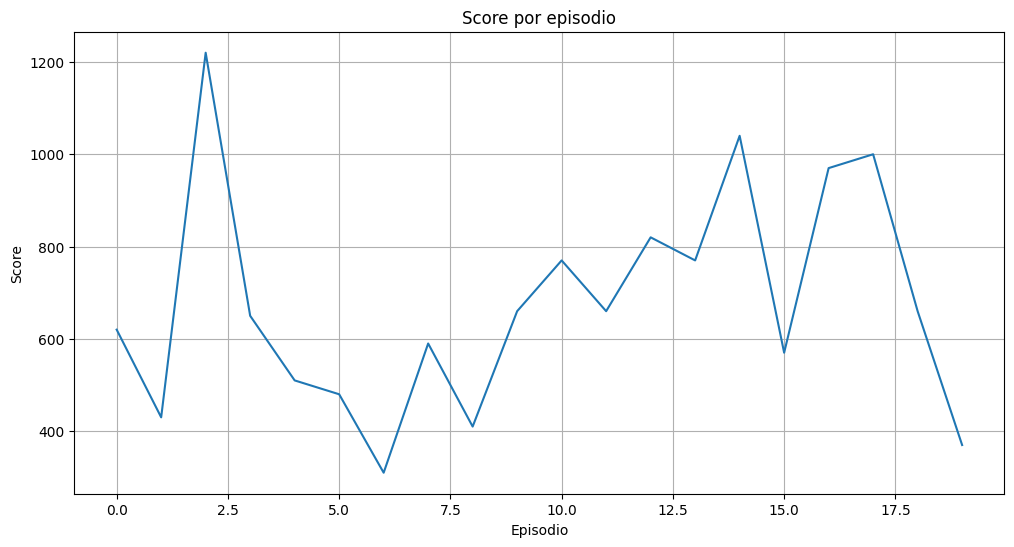

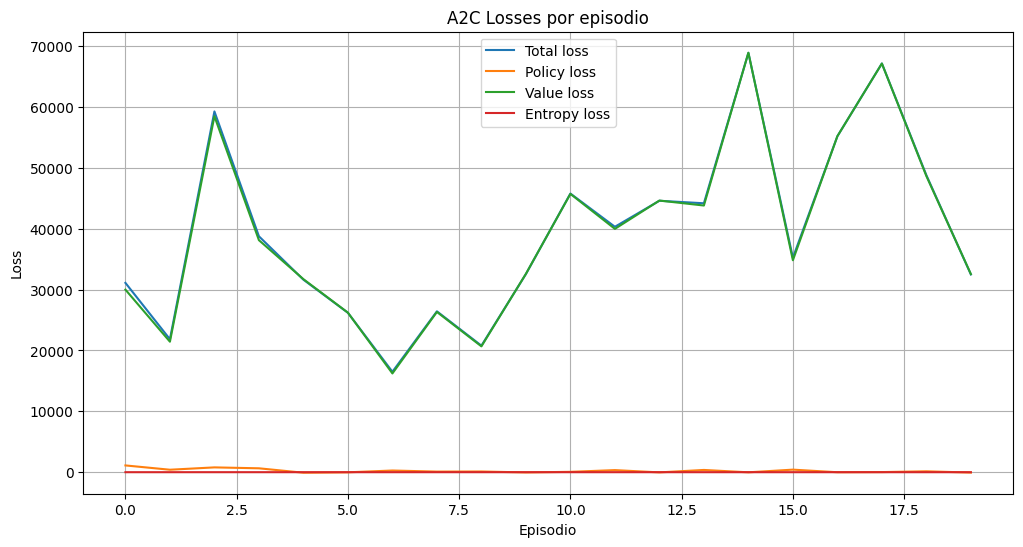

In [23]:
train_a2c(episodes=20)